# Visualizing Attention Masks in Transformer Model

In [1]:
import os
import numpy as np
import torch
from matplotlib import pyplot as plt

import lib.visualizations as visualizations
from lib.visualizations import COLORS

from CONFIG import CONFIG
CONFIG["paths"]["data_path"] = os.path.join(os.getcwd(), "..", "..", "datasets")

/home/user/villar/anaconda3/envs/VideoPred/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
EXP_PATH = "/home/user/villar/ObjectCentricVideoPred/experiments/NewExps/NewSAVI2"
SA_MODEL = "checkpoint_epoch_final_converted.pth"
CHECKPOINT = "checkpoint_epoch_final.pth"
NAME_PRED_EXP = "OVTransformerV1_NumLayers=4_TeacherForcing=False_SkipFirst=False_Residual"

In [4]:
fig_generator_script = __import__('aux_generate_figs_pred')
figGenerator = fig_generator_script.FigGenerator(
        exp_path=EXP_PATH,
        sa_model_directory=SA_MODEL,
        checkpoint=CHECKPOINT,
        name_predictor_experiment=NAME_PRED_EXP,
        num_seqs=10
    )

In [5]:
figGenerator.load_data()
figGenerator.load_model(exp_path=figGenerator.parent_exp_path)
figGenerator.load_predictor()

Initializer:
  --> mode=LearnedRandom
  --> slot_dim=128
  --> num_slots=6
Encoder:
  --> Encoder_type=ConvEncoder
  --> Downsample_encoder=False
  --> in_channels=3
  --> num_channels=[32, 32, 32, 32]
  --> kernel_size=5
resolution: [64, 64] , hidden_size: 32
Decoder:
  --> Resolution=[64, 64]
  --> Num channelsl=[32, 32, 32, 32]
  --> Upsample=2
  --> Downsample_encoder=False
  --> Downsample_decoder=True
  --> Decoder_resolution=[8, 8]
resolution: [8, 8] , hidden_size: 128
Instanciating Object-Centric Transformer-v1 Predictor:
  --> num_layers: 4
  --> input_dim: 128
  --> token_dim: 128
  --> hidden_dim: 256
  --> num_heads: 4
  --> residual: True
  --> batch_first: True
  --> norm_first: True


# Attention Visualization

## Preparing Data

In [6]:
num_context = figGenerator.exp_params["training_prediction"]["num_context"]
num_preds = figGenerator.exp_params["training_prediction"]["num_preds"]
video_length = figGenerator.exp_params["training_prediction"]["sample_length"]

num_slots = figGenerator.model.num_slots
slot_dim = figGenerator.model.slot_dim

In [37]:
IDX = 0
batch_data = figGenerator.test_set[IDX]

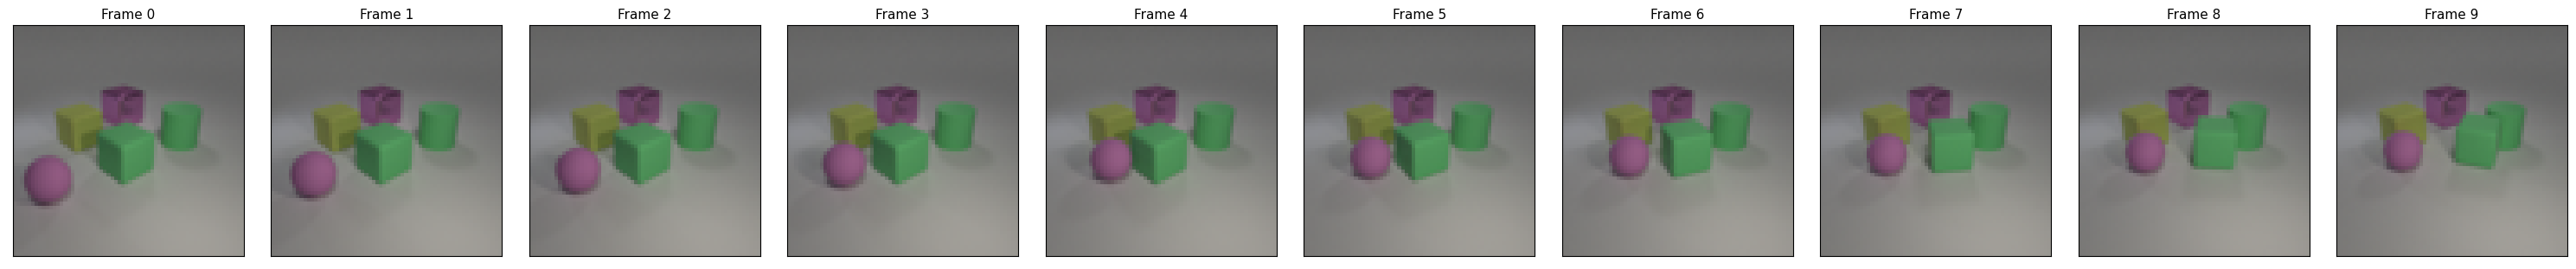

In [38]:
_ = visualizations.visualize_sequence(batch_data[10:20])

In [39]:
cur_data = batch_data[5:20]
videos, initializer_data = figGenerator.unwrap_batch_data(cur_data)
videos = videos.unsqueeze(0).to(figGenerator.device)
initializer_data = {k: v.unsqueeze(0) for k, v in initializer_data.items() if torch.is_tensor(v)}

## Computing Object Slots

In [40]:
B, L, C, H, W = videos.shape

# computing slots with pretrained SAVI  
with torch.no_grad():
    slot_history, reconstruction_history, individual_recons_history, masks_history = figGenerator.model(videos, num_imgs=L)
obj_history = individual_recons_history * masks_history
obj_history = obj_history[0, 5:5+num_context]
mask_history = masks_history[0, 5:5+num_context]

slot_history = slot_history[:, 5:]
videos_disp = videos[:, 5:]

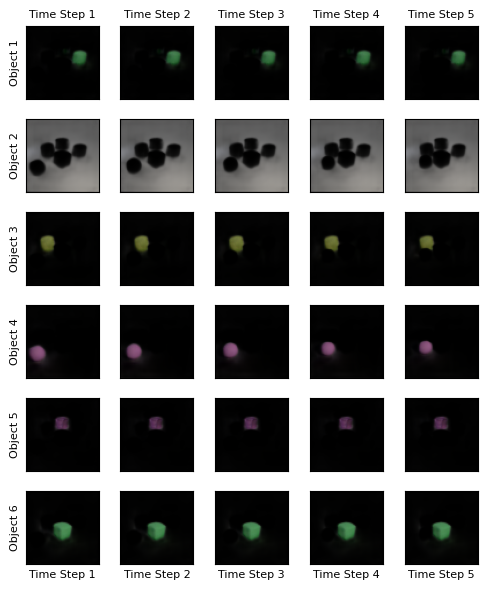

In [41]:
_ = visualizations.visualize_aligned_slots(obj_history, mult=1, fontsize=8)

## Single Prediction Step and Decoding Objects

In [42]:
# predict one slot in the future
pred_slots = []
predictor_input = slot_history[:, :num_context].clone()

cur_preds = figGenerator.predictor(predictor_input)[:, -1]
pred_slots.append(cur_preds)
pred_slots = torch.stack(pred_slots, dim=1)  # (B, num_preds, num_slots, slot_dim)

In [43]:
img_recons, (pred_recons, pred_masks) = figGenerator.model.decode(cur_preds)
pred_objs = pred_recons * pred_masks

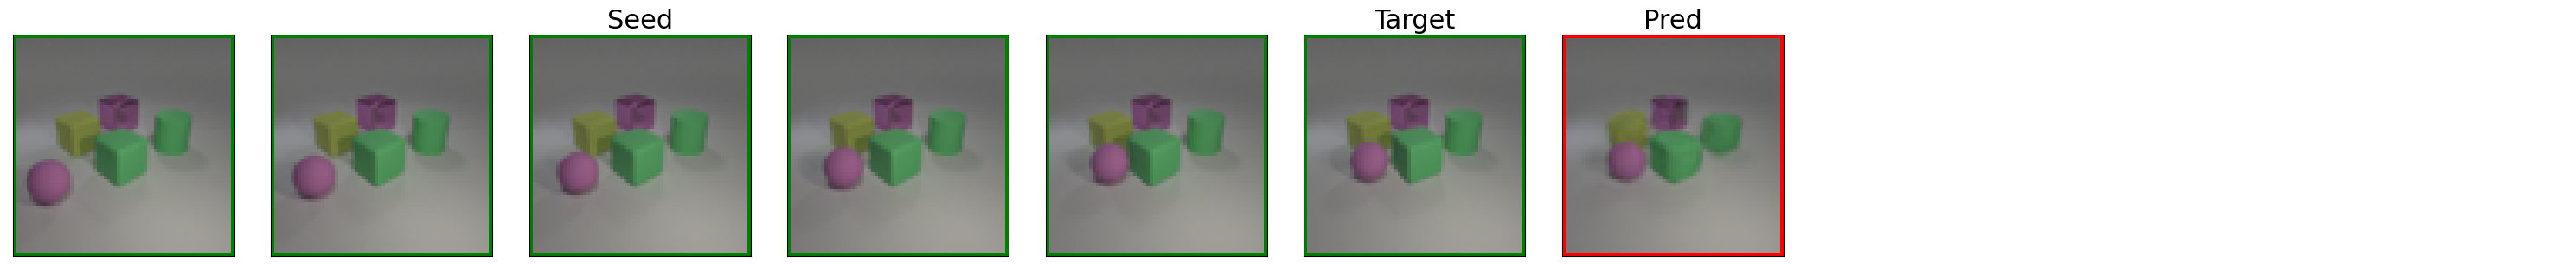

In [44]:
seed = visualizations.add_border(videos_disp[0, :num_context], color_name="green")
target = visualizations.add_border(videos_disp[0, num_context:num_context+1], color_name="green")
preds = visualizations.add_border(img_recons, color_name="red")

all_imgs = torch.cat([seed, target, preds])
_ = visualizations.visualize_sequence(all_imgs, titles=["", "", "Seed", "", "", "Target", "Pred"], font_size=22)

In [45]:
max_masks = pred_masks.argmax(dim=1)[0, 0]

In [46]:
def invert_masks(objs, masks):
    """ """
    objs_ = objs.clone()
    max_masks = pred_masks.argmax(dim=1)[0, 0]
    for i in range(objs.shape[0]):
        objs_[i, :, max_masks != i] = 1
    return objs_

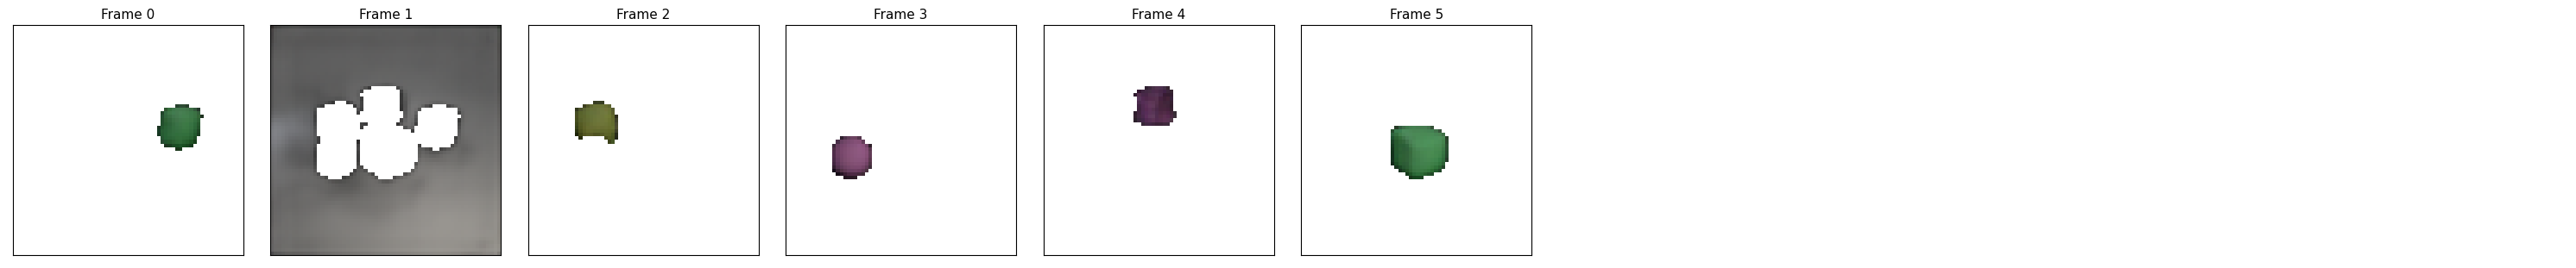

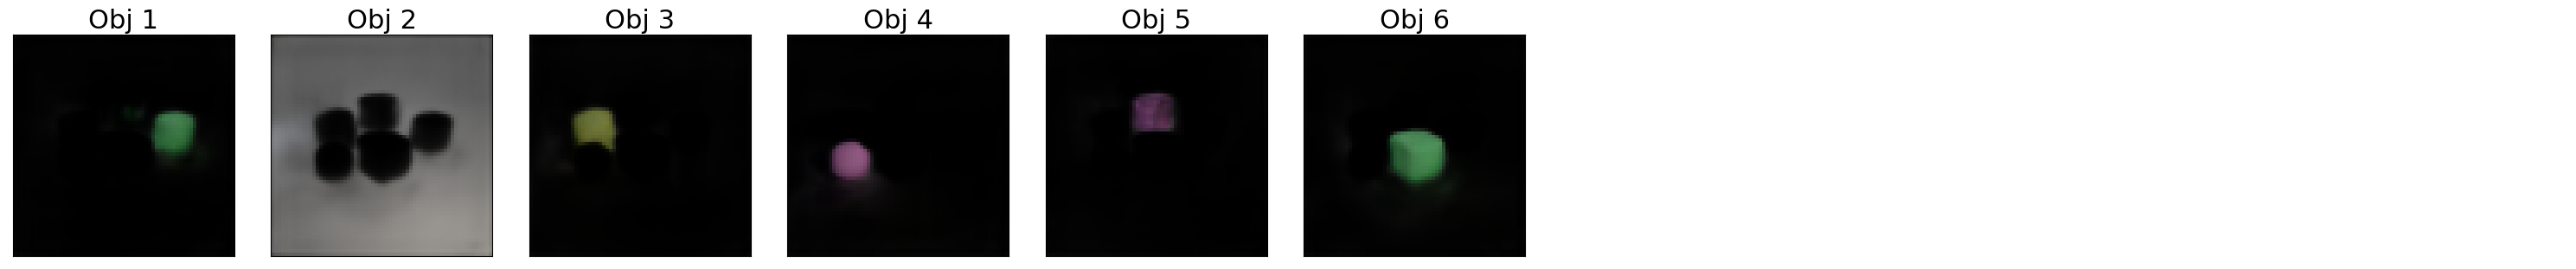

In [47]:
pred_objs_ = invert_masks(pred_objs[0], pred_masks[0])
_ = visualizations.visualize_sequence(pred_objs_)

_ = visualizations.visualize_sequence(pred_objs[0], font_size=22, titles=[f"Obj {i+1}" for i in range(num_slots)])

## Attention Maps

In [48]:
object_attn_weights, time_attn_weights= figGenerator.predictor.get_attn_maps(predictor_input)

print(f"{object_attn_weights.shape = }")
print(f"{time_attn_weights.shape = }")

object_attn_weights.shape = torch.Size([1, 5, 6, 6])
time_attn_weights.shape = torch.Size([1, 6, 5, 5])


# Object Attention

In [49]:
def norm_attention_matrix(matrix, norm=None):
    """
    Normalizing the attention matrix
    
    norm: string
        Normalization type: ['rows', 'max', None]
    """
    assert norm in ["rows", "max", None]
    matrix = matrix.detach().cpu()
    if norm == "rows":
        matrix = matrix / matrix.max(dim=-1, keepdim=True)[0]
    elif norm == "max":
        matrix = matrix / matrix.max()
    else:
        pass
    return matrix

def temperature_softmax(x, temperature):
    """ """
    y = torch.softmax(x / temperature, dim=-1)
    return y

In [50]:
def plot_matrix(matrix, cmap="coolwarm", vmin=0, vmax=1, norm=None, title=None, fig=None, ax=None, textsize=12):
    """
    Visualizing an attention matrix
    """
    assert norm in ["rows", "max", "norm_colorbar", None]
    matrix = matrix.detach().cpu()
    if fig is None and ax is None:
        fig, ax = plt.subplots()
    
    if norm == "rows":
        matrix = matrix / matrix.max(dim=-1, keepdim=True)[0]
    elif norm == "max":
        matrix = matrix / matrix.max()
    elif norm == "norm_colorbar":
        vmax = matrix.max()
    else:
        pass
    
    im = ax.imshow(matrix, cmap=cmap, vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=ax)
    # plt.xticks(range(attn_map.shape[0]), [f"slot_{i}" for i in range(attn_map.shape[0])], rotation=45, fontsize=6)
    # plt.yticks(range(attn_map.shape[0]), [f"slot_{i}" for i in range(attn_map.shape[0])], rotation=45, fontsize=6)
    ax.set_xlabel("Input")
    ax.set_ylabel("Output")

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            text = ax.text(j, i, round(matrix[i, j].item(), 2), ha="center", va="center", color="w", fontsize=textsize)
    
    if title is not None:
        ax.set_title(title)
    return

def plot_view_matrix(matrix, cmap="coolwarm", vmin=0, vmax=1, textsize=12):
    """
    Displaying multiple normalizations of an attention matrix
    """
    fig, ax = plt.subplots(1, 4)
    fig.set_size_inches(30, 8)

    plot_matrix(matrix, norm=None, title="Raw Att-Matrix", fig=fig, ax=ax[0], textsize=textsize)
    plot_matrix(matrix, norm="norm_colorbar", title="Raw Att-Matrix", fig=fig, ax=ax[1], textsize=textsize)
    plot_matrix(matrix, norm="rows", title="Rowwise-Norm Att-Matrix", fig=fig, ax=ax[2], textsize=textsize)
    plot_matrix(matrix, norm="max", title="Max-Norm Att-Matrix", fig=fig, ax=ax[3], textsize=textsize)
    plt.tight_layout()
    return

def display_sorted_objs_attention(att_mat, pred_objs, obj_history):
    """
    Displaying the predicted objects next to the past objects, sorted by their attention value
    """
    att_vals, obj_idx = att_mat.sort(dim=-1, descending=True)
    H, W = att_vals.shape

    fig, ax = plt.subplots(H, W+1)
    fig.set_size_inches((W+1) * 1, H * 1.)
    plt.subplots_adjust(wspace=0., hspace=0.8)

    for i in range(H):
        ax[i, 0].imshow(pred_objs[0, i].detach().cpu().permute(1, 2, 0).clamp(0, 1))
        ax[i, 0].set_title(f"Pred Object {i+1}", fontsize=8)
        for j in range(W):
            att_val, idx = att_vals[i, j], obj_idx[i, j]
            ax[i, j+1].imshow(obj_history[-1, idx].detach().cpu().permute(1, 2, 0).clamp(0, 1))
            ax[i, j+1].set_title(f"Obj {idx} \n Att = {round(att_val.item(), 2)}", fontsize=8)

    for a in ax:
        for a_ in a:
            a_.set_xticks([], [])
            a_.set_yticks([], [])
    return


def plot_rgb_attention_masks(att_mat, masks):
    """
    Displaying the predicted objects, along with an RGB mask of the objects it attends to
    """
  
    # normalization
    # att_mat = norm_attention_matrix(att_mat.cpu(), norm="rows")
    att_mat = temperature_softmax(att_mat, temperature=1e-1)

    att_vals, obj_idx = att_mat.sort(dim=-1, descending=True)
    H, W = att_vals.shape

    fig, ax = plt.subplots(2, H)
    fig.set_size_inches(H * 2, 4)
    plt.subplots_adjust(wspace=0.01, hspace=0.01)

    for i in range(H):
        cur_colors = ["seashell"] + [COLORS[1:H+1][idx] for idx in obj_idx[i]]
        scaled_masks = masks[-1, obj_idx[i]] * att_vals[i].view(-1, 1, 1, 1)
        masks_rgb = visualizations.instances_to_rgb(
                scaled_masks.argmax(dim=0),
                num_channels=scaled_masks.shape[0],
                colors=cur_colors
            )
        scaled_masks_rgb = torch.stack([m * masks_rgb[0] for m in scaled_masks.cpu()])
        scaled_full_mask_rgb = scaled_masks_rgb.max(dim=0)[0]

        ax[0, i].imshow(pred_objs[0, i].detach().cpu().permute(1, 2, 0).clamp(0, 1))
        ax[0, i].set_title(f"Pred. Object {i+1}", fontsize=12)
        ax[1, i].imshow(scaled_full_mask_rgb.detach().cpu().permute(1, 2, 0).clamp(0, 1))

    ax[1, 0].set_ylabel("Attention", fontsize=12, rotation=90)     
    for a in ax:
        for a_ in a:
            a_.set_xticks([], [])
            a_.set_yticks([], [])
            
def plot_attention_masks_rgb(att_mat, masks):
    """
    """
    # normalization
    att_mat = temperature_softmax(att_mat, temperature=1e-1)

    att_vals, obj_idx = att_mat.sort(dim=-1, descending=True)
    H, W = att_vals.shape    
    

    for i in range(H):
        cur_colors = ["seashell"] + [COLORS[1:H+1][idx] for idx in obj_idx[i]]
        scaled_masks = masks[-1, obj_idx[i]] * att_vals[i].view(-1, 1, 1, 1)
        masks_rgb = visualizations.instances_to_rgb(
                scaled_masks.argmax(dim=0),
                num_channels=scaled_masks.shape[0],
                colors=cur_colors
            )
        scaled_masks_rgb = torch.stack([m * masks_rgb[0] for m in scaled_masks.cpu()])
        scaled_mask_rgb = scaled_masks_rgb.max(dim=0)[0]
        all_masks_rgb = torch.cat([scaled_mask_rgb.unsqueeze(0), scaled_masks_rgb])
        
        titles = [f"Mask Obj. {i+1}"] + [f"Att. Obj {j+1}" for j in range(W)]
        _ = visualizations.visualize_sequence(all_masks_rgb, titles=titles, font_size=20)

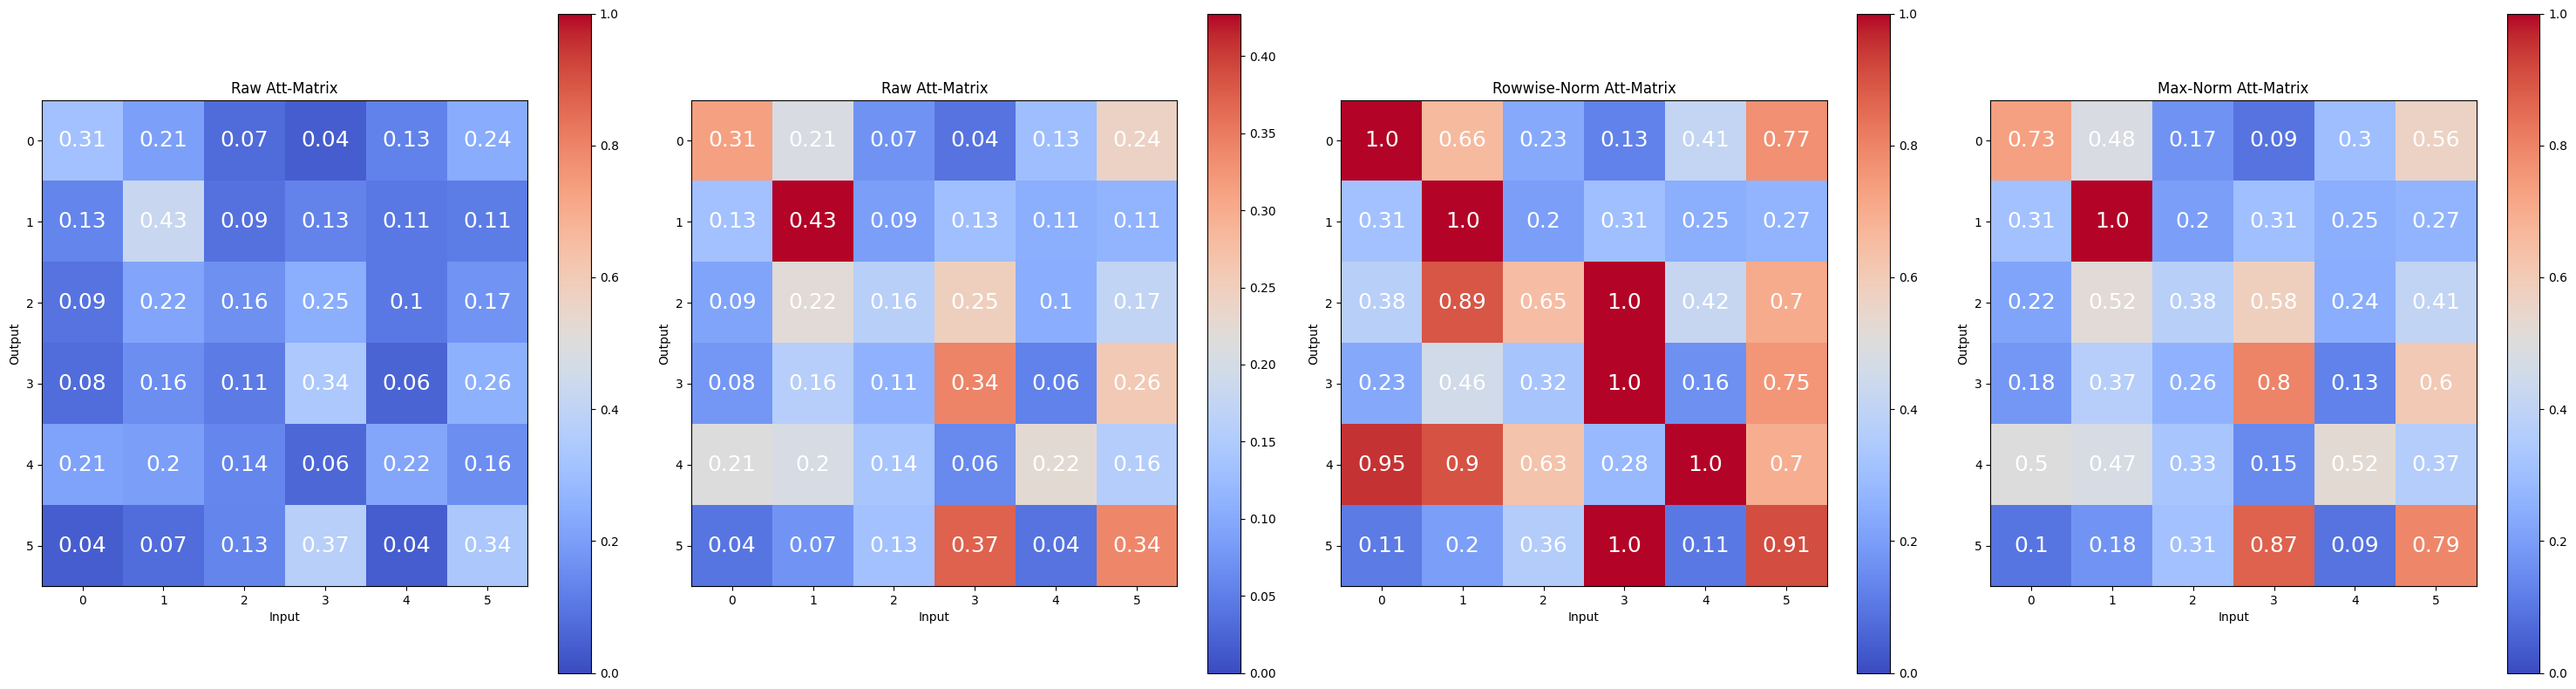

In [51]:
textsize = 18
plot_view_matrix(object_attn_weights[0, -1], textsize=textsize)

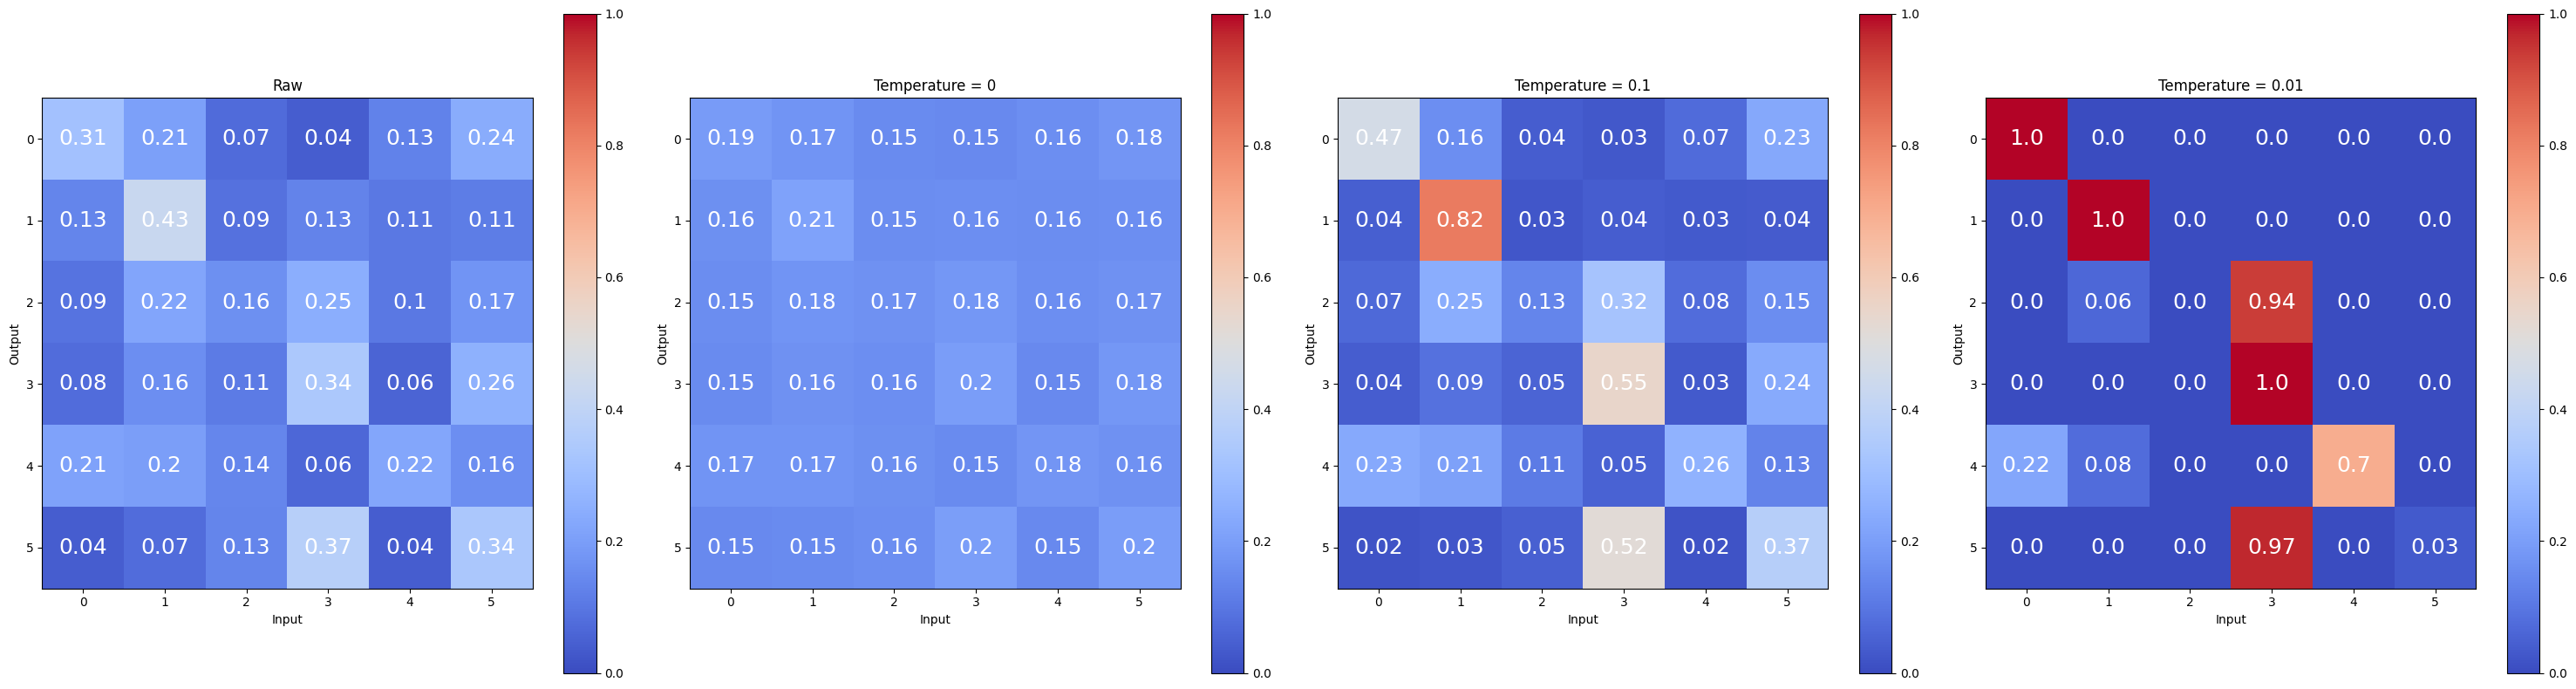

In [52]:
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(30, 8)

att_matrix = object_attn_weights[0, -1]

plot_matrix(att_matrix, norm=None, fig=fig, ax=ax[0], textsize=textsize, title="Raw")
plot_matrix(temperature_softmax(att_matrix, temperature=1e-0), norm=None, fig=fig, ax=ax[1], textsize=textsize, title="Temperature = 0")
plot_matrix(temperature_softmax(att_matrix, temperature=1e-1), norm=None, fig=fig, ax=ax[2], textsize=textsize, title="Temperature = 0.1")
plot_matrix(temperature_softmax(att_matrix, temperature=1e-2), norm=None, fig=fig, ax=ax[3], textsize=textsize, title="Temperature = 0.01")
plt.tight_layout()

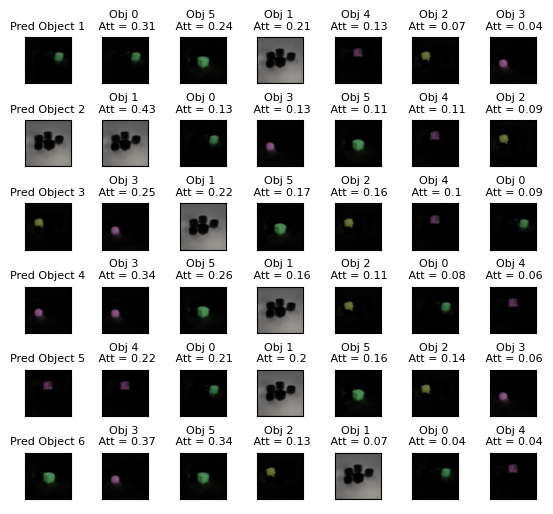

In [53]:
display_sorted_objs_attention(
        att_mat=object_attn_weights[0, -1],
        pred_objs=pred_objs,
        obj_history=obj_history
    )    

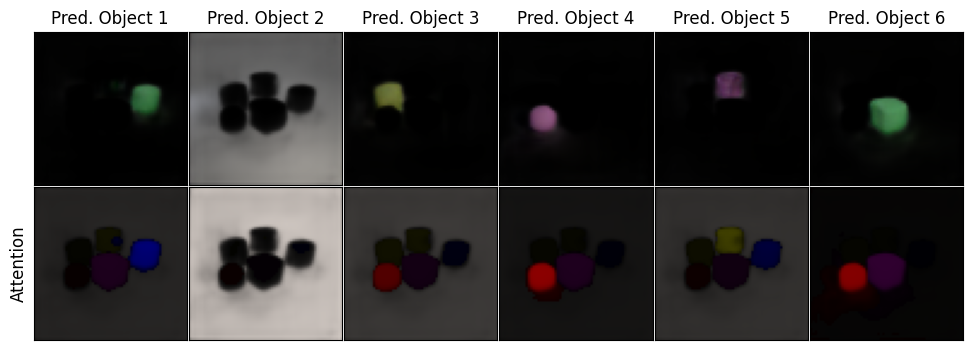

In [54]:
plot_rgb_attention_masks(
        att_mat=object_attn_weights[0, -1].cpu(),
        masks=mask_history.cpu()                 
    )

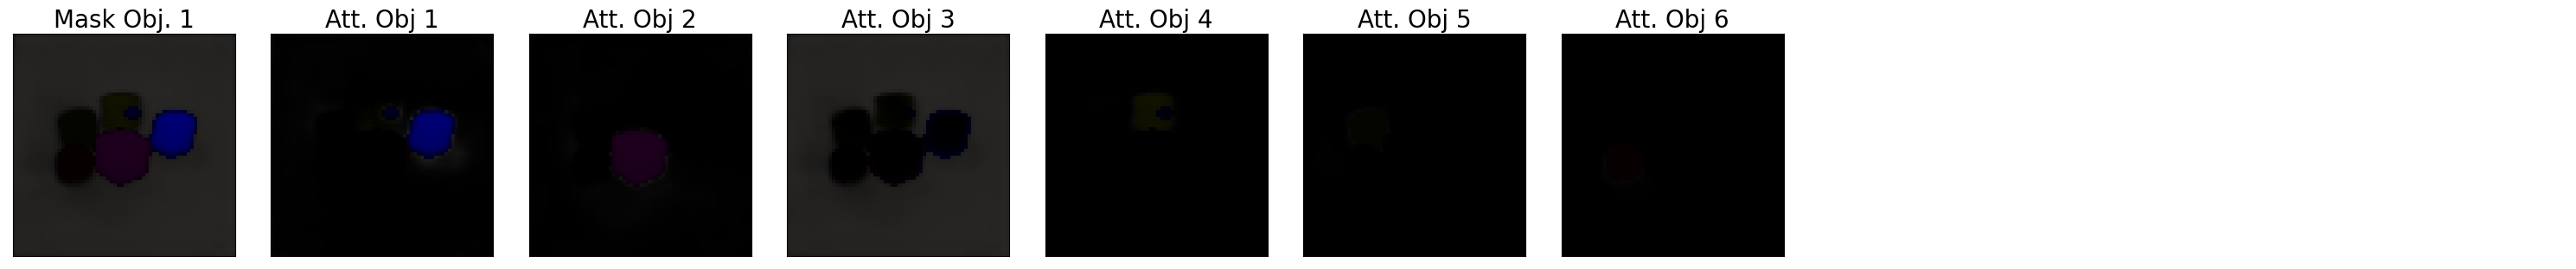

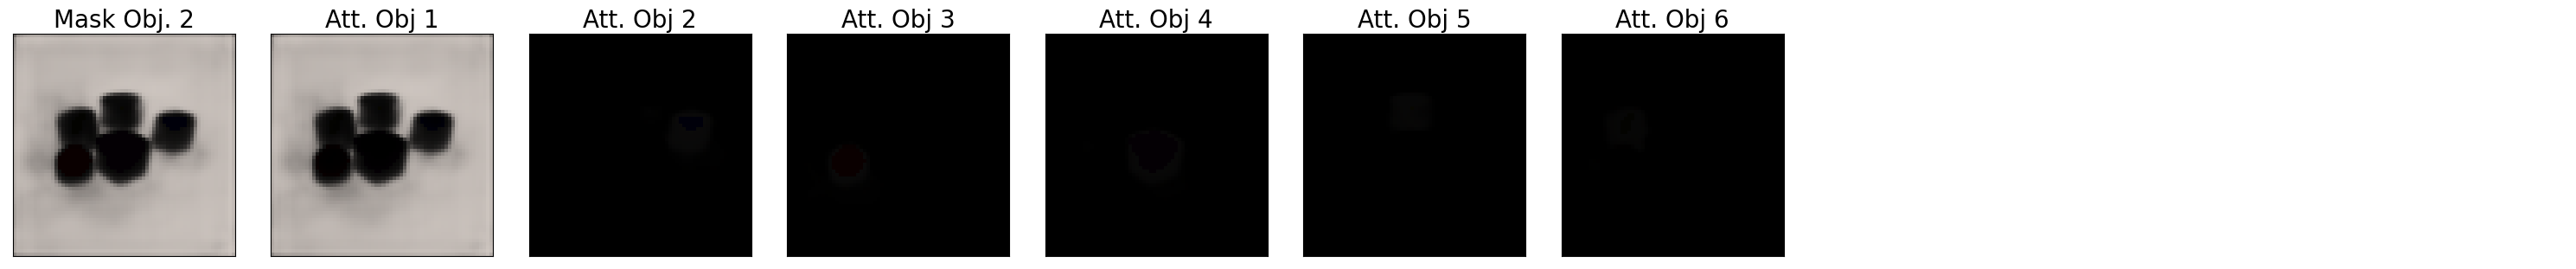

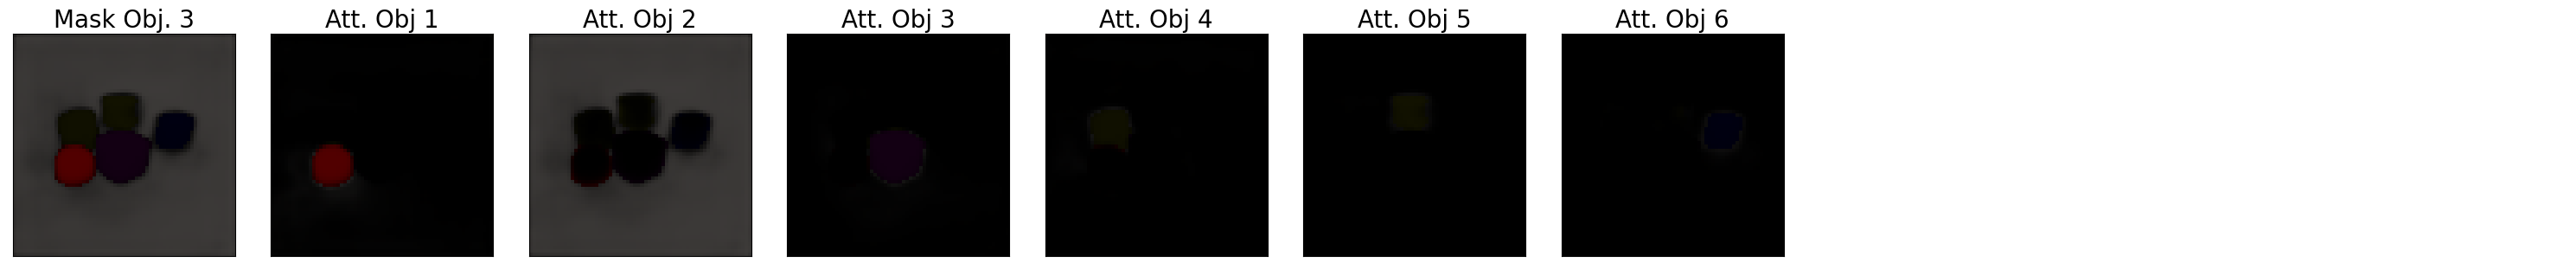

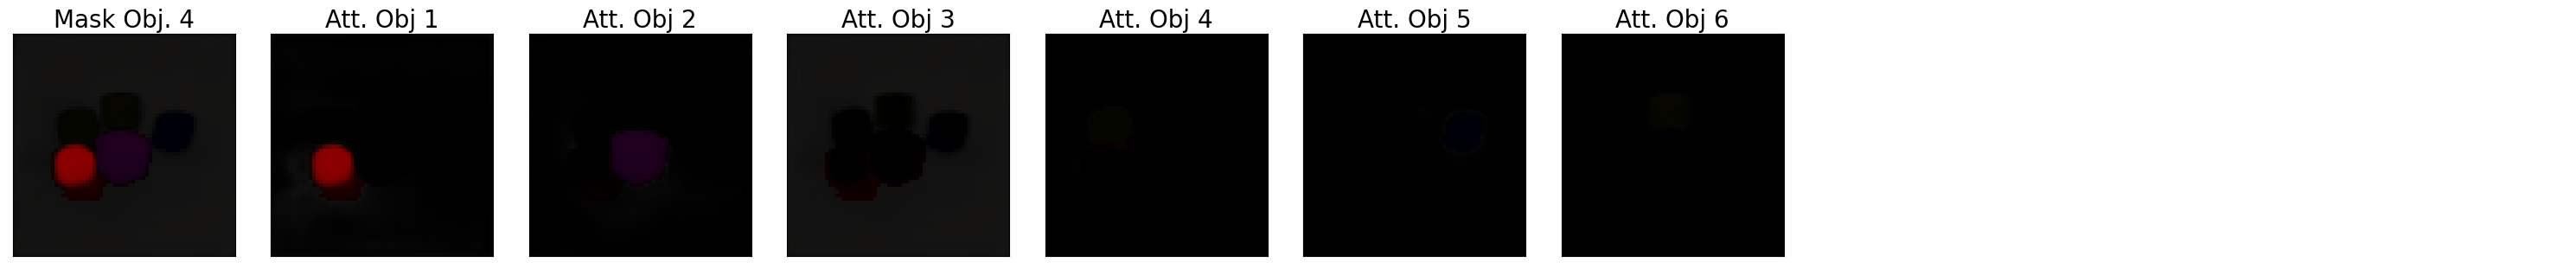

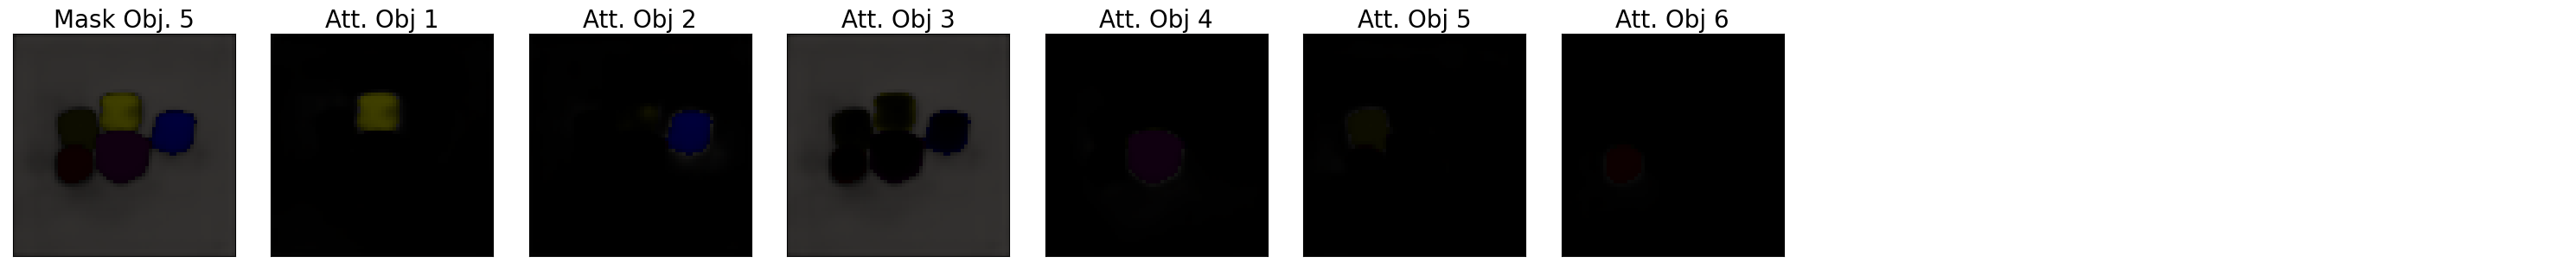

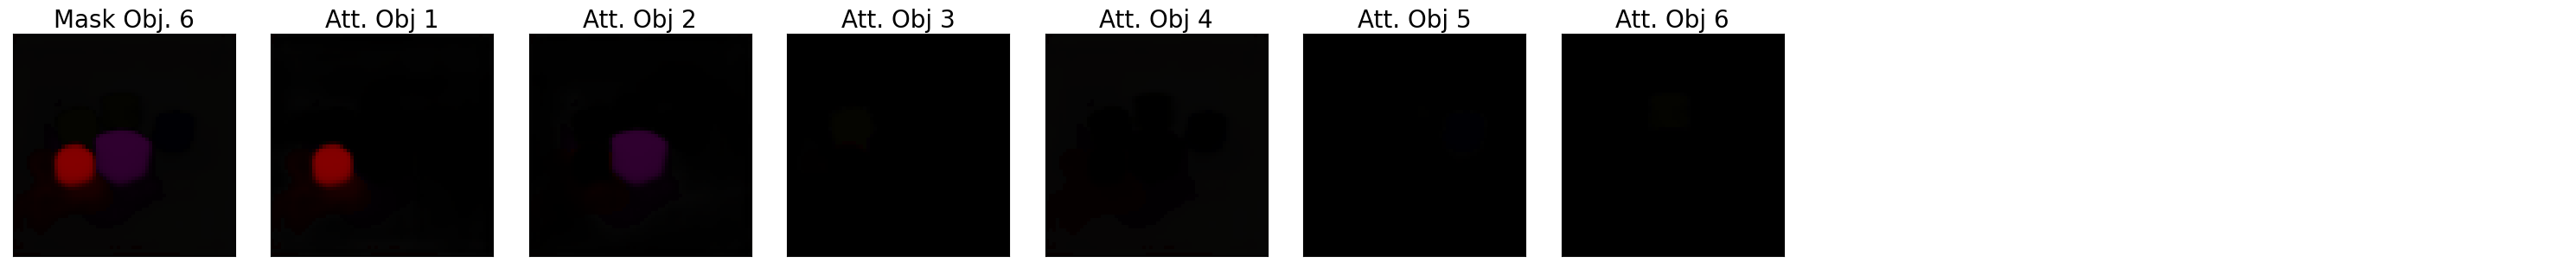

In [56]:
plot_attention_masks_rgb(
        att_mat=object_attn_weights[0, -1].cpu(),
        masks=mask_history.cpu()                 
    )

# Time Attention

In [57]:
_, time_attn_weights= figGenerator.predictor.get_attn_maps(predictor_input)

print(f"{time_attn_weights.shape = }")

time_attn_weights.shape = torch.Size([1, 6, 5, 5])


In [58]:
time_attention = time_attn_weights[0, :, -1]

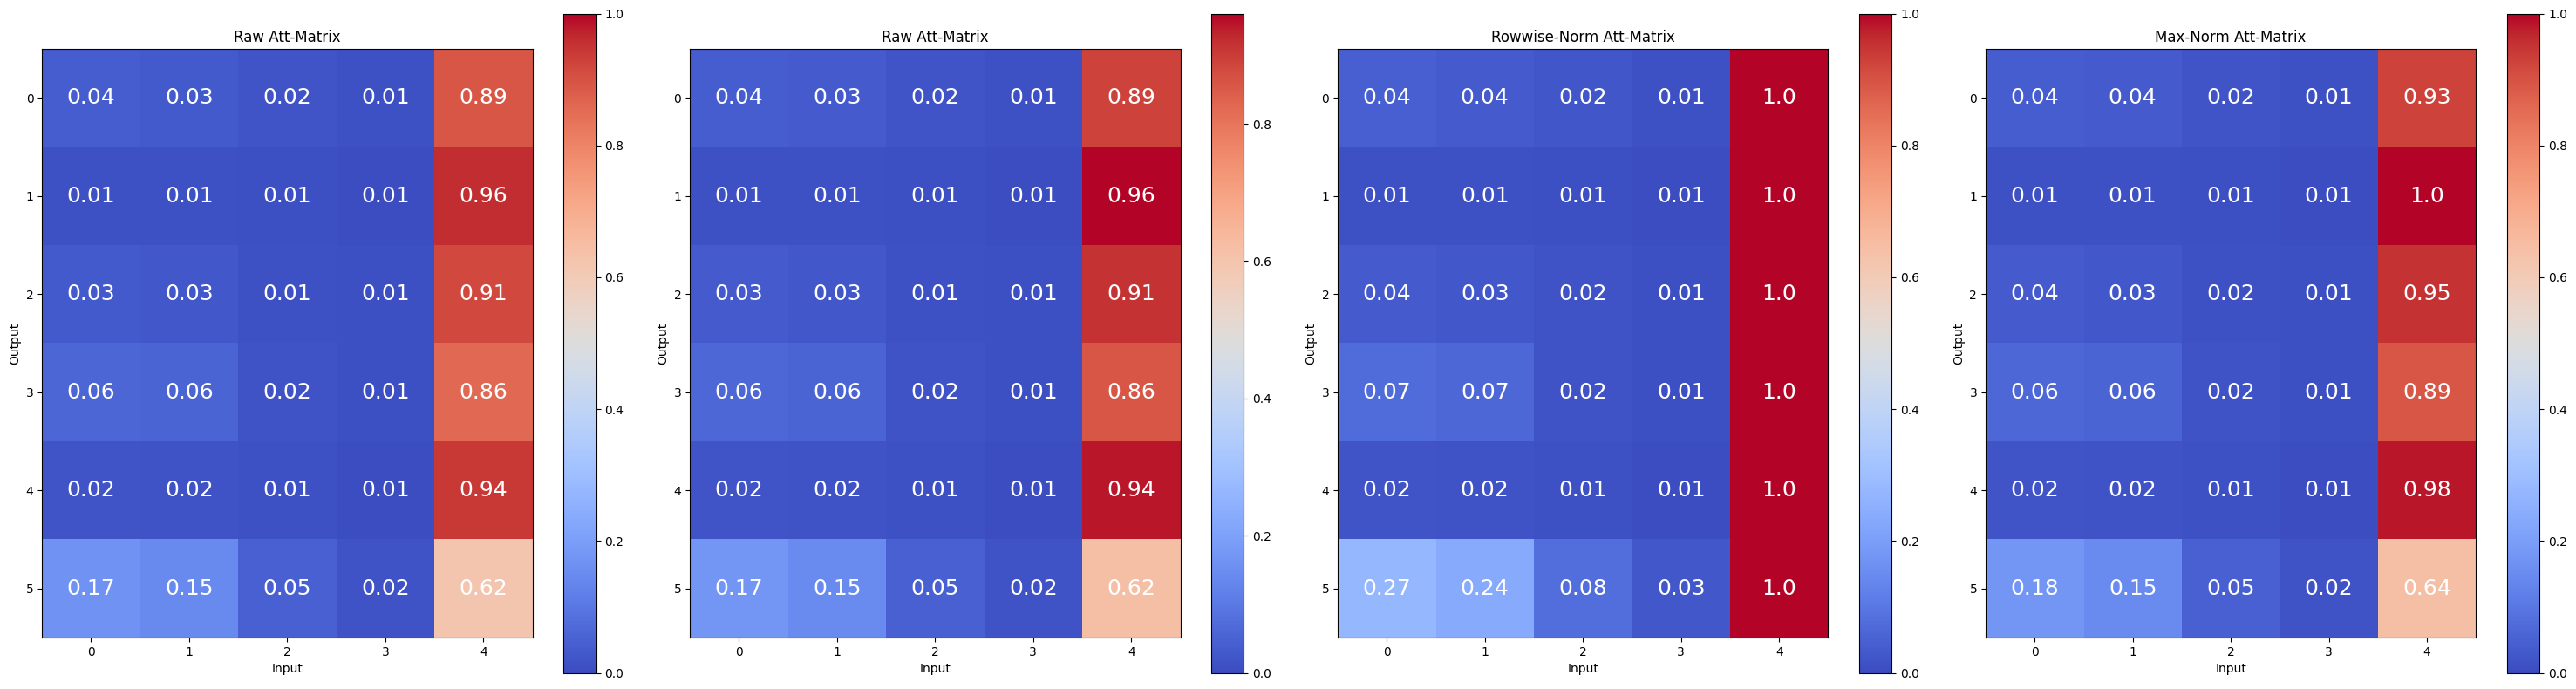

In [59]:
textsize = 18
plot_view_matrix(time_attention, textsize=textsize)

## Visualizations

In [ ]:
IDX = 0

In [ ]:
fig, ax = visualizations.visualize_tight_row(frames=videos[IDX], num_context=5, is_gt=True)
fig, ax = visualizations.visualize_tight_row(frames=pred_imgs[IDX], num_context=5, is_gt=False)

In [ ]:
masks_categorical = masks_history[IDX].argmax(dim=1)
pred_masks_categorical = pred_masks.argmax(dim=1)

In [ ]:
masks_vis = visualizations.masks_to_rgb(x=masks_categorical)
pred_masks_vis = visualizations.masks_to_rgb(x=pred_masks_categorical)

In [ ]:
_ = visualizations.visualize_sequence(masks_vis[5:15, 0])
_ = visualizations.visualize_sequence(pred_masks_vis[:10, 0])

In [ ]:
masks_categorical_channels = visualizations.idx_to_one_hot(x=masks_categorical)
disp_overlay = visualizations.overlay_segmentations(
        videos[IDX, :10].cpu().detach(),
        masks_categorical_channels[:10, 0].cpu().detach(),
        colors=COLORS,
        alpha=0.6
    )

_ = visualizations.visualize_sequence(disp_overlay[:10])